# Scale Invariance CNN

## Introduction: 

In this assignment, scale invariance CNN is investigated.  MNIST datasets are resized at various scales and shuffled. First, LeNet CNN is used to train and test scaled datasets and accuracy is reported for each scale. Second, the CNN is trained on the original MNIST dataset (e.g. no scaling) and tested on scaled datasets for transfer learning study.  Last, a multi-CNN approach is attempted where image scale is identified via a CNN and used to revert images to original images before testing on another CNN which has been trained on the original images.

## Results and Discussion

### Scaling: 
Six MNIST datasets are scaled at 100%, 75%, 67%, 50%, 33% and 25%. I couldn't split MNIST datasets consisting 60,000 images so I use six copies.  Scaling of 100% is no scaling.  Others are scaling down since scaling would cut digits, as MNIST images take very much the whole image frame, whereas scaling down retains all digit features. Scaling down is performed by transforms.resize and transforms.pad to retain the original shape of 28x28.
 A sample of scaled images is shown below.

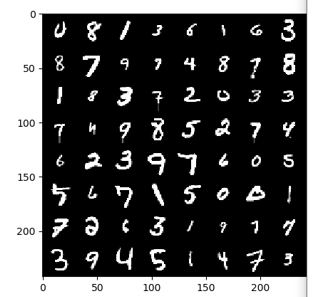

### 1. Trained and tested on scaled datasets:
The accuracy is about 98% for mixed-scale images (e.g. all scaling levels) and for individual-scale images (one scaling level at a time). Even a simple CNN like LeNet is very effective to learn scaled images.

### 2. Trained on original datasets and tested on scaled datasets:
The accuracy is about 76% for mixed-scale images and 98%-34% for individual-scale images.  This part can be considered as transfer learning - a CNN trained on original images is used to test scaled images.  I think this performance can be improved if the classifier part (e.g. FCs) is retrained with some scaled images.  

### 3. Multi-CNN:
Two CNNs are used. One CNN is trained on original datasets as a traditional digit classifier.  The other CNN is trained on scaled datasets as a scale classifier. Each image is fed to the scale classifier to identify image's scale level (i.e. 100%, 75%) which then used to reversely scale the image to recover the original image before sending to the digit classifier.  The scale classifier is tested with accuracy 97%. 
Diagram of the process is shown below.

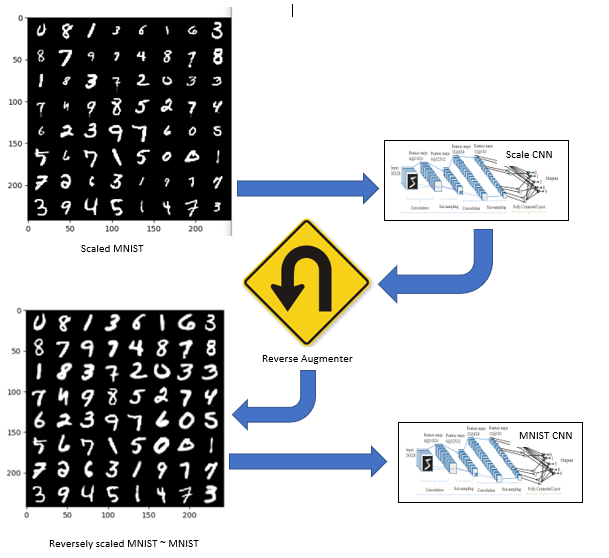

It turns out that that the accuracy attained is about 97% for both mixed-scale images and individual-scale images. This method seems to be similar to human approach: first getting a good view of an image before classifying.  A similar approach is used for rotation, shear and affine images.

## Summary:

In this assignment, we investigated scale invariant CNN. we found that LeNet can learn scale images quite well but transfer learning is limited. A multi-CNN approach is attempted with comparable performance as learning on scaled images.  The overall results are shown in table below.

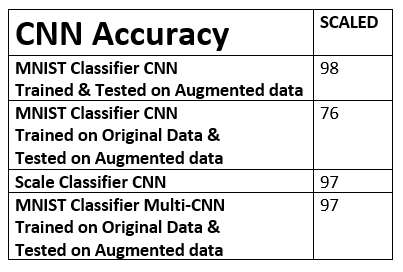

The codes are shown below:

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import ConcatDataset as _ConcatDataset
from torch.utils.data.dataset import Subset
from torchvision import transforms, utils
import sys
import numpy as np

import matplotlib as matplotlib
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # if batch_idx == 0:
        #     print("1st batch train targets and images")
        #     print(target)
        #     grid = utils.make_grid(data)
        #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
            # plt.show()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx % args.log_interval == 0:
        #     print(scale)
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))


def test(args, model_digit, model_scale, device, test_loader, method):
    model_digit.eval()
    model_scale.eval()
    test_loss = 0
    correct = 0
    if method != 2:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                # if test_loss == 0:
                #     print("1st batch Test targets and images")
                #     print(target[0:64])
                #     grid = utils.make_grid(data[0:64])
                #     plt.imshow(grid.numpy().transpose((1, 2, 0)))
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()
    else:  # method 2
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                if test_loss == 0:
                    print("1st batch Test targets and images")
                    print(target[0:64])
                    plt.figure(0)
                    grid = utils.make_grid(data[0:64])
                    plt.imshow(grid.numpy().transpose((1, 2, 0)))

                output_scale = model_scale(data)
                pred_scale = output_scale.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                for i in range(len(data)):
                    predictme = pred_scale[i][0]
                    if predictme == 1:
                        resize = 28
                    elif predictme == 2:
                        resize = 32
                    elif predictme == 3:
                        resize = 34
                    elif predictme == 4:
                        resize = 40
                    elif predictme == 5:
                        resize = 48
                    elif predictme == 6:
                        resize = 56
                    data[i] = data[i] * 0.3081 + 0.1307  # de-normalized
                    data_img = transforms.ToPILImage()(data[i])
                    data[i] = transforms.Compose([
                        transforms.Resize(resize),
                        transforms.CenterCrop(28),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])(data_img)

                if test_loss == 0:
                    plt.figure(1)
                    grid = utils.make_grid(data[0:64])
                    plt.imshow(grid.numpy().transpose((1, 2, 0)))

                # predict digit of reverted images using the model_digit trained on original data
                output_digit = model_digit(data)
                test_loss += F.nll_loss(output_digit, target, reduction='sum').item()  # sum up batch loss
                pred_digit = output_digit.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred_digit.eq(target.view_as(pred_digit)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def load_train_data(args, kwargs, traintype):
    d1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    d2 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(24),
                           transforms.Pad(padding=2, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    d3 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(22),
                           transforms.Pad(padding=3, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    d4 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(20),
                           transforms.Pad(padding=4, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    d5 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(16),
                           transforms.Pad(padding=6, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    d6 = datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.Compose([
                           transforms.Resize(14),
                           transforms.Pad(padding=7, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                        ]))
    if traintype == 1:
        d1.train_labels[:] = 1  # 100% scale
        d2.train_labels[:] = 2  # 75% scale
        d3.train_labels[:] = 3  # 67% scale
        d4.train_labels[:] = 4  # 50% scale
        d5.train_labels[:] = 5  # 33% scale
        d6.train_labels[:] = 6  # 25% scale

    Comb_data = _ConcatDataset([d1, d2, d3, d4, d5, d6])
    train_loaderA = torch.utils.data.DataLoader(
        Comb_data, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader1 = torch.utils.data.DataLoader(
        d1, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader2 = torch.utils.data.DataLoader(
        d2, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader3 = torch.utils.data.DataLoader(
        d3, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader4 = torch.utils.data.DataLoader(
        d4, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader5 = torch.utils.data.DataLoader(
        d5, batch_size=args.batch_size, shuffle=True, **kwargs)
    train_loader6 = torch.utils.data.DataLoader(
        d6, batch_size=args.batch_size, shuffle=True, **kwargs)
    return train_loader1, train_loaderA


def load_test_data(args, kwargs, testtype):
    t1 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    t2 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(24),
                           transforms.Pad(padding=2, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    t3 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(22),
                           transforms.Pad(padding=3, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    t4 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(20),
                           transforms.Pad(padding=4, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    t5 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(16),
                           transforms.Pad(padding=6, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    t6 = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(14),
                           transforms.Pad(padding=7, padding_mode='edge'),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    # only used to evaluate SCALE CLASSIFIER CNN
    if testtype == 1:
        t1.test_labels[:] = 1  # 100% scale
        t2.test_labels[:] = 2  # 75% scale
        t3.test_labels[:] = 3  # 67% scale
        t4.test_labels[:] = 4  # 50% scale
        t5.test_labels[:] = 5  # 33% scale
        t6.test_labels[:] = 6  # 25% scale

    comb_test = _ConcatDataset([t1, t2, t3, t4, t5, t6])
    test_loaderA = torch.utils.data.DataLoader(
        comb_test, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader1 = torch.utils.data.DataLoader(
        t1, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader2 = torch.utils.data.DataLoader(
        t2, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader3 = torch.utils.data.DataLoader(
        t3, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader4 = torch.utils.data.DataLoader(
        t4, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader5 = torch.utils.data.DataLoader(
        t5, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    test_loader6 = torch.utils.data.DataLoader(
        t6, batch_size=args.test_batch_size, shuffle=True, **kwargs)
    return test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, test_loader5, test_loader6


def runit(args, device, train_loader_scale, train_loader_digit, test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, test_loader5, test_loader6, method):
    model_digit = Net().to(device)
    model_scale = Net().to(device)
    print(model_digit)
    optimizer_digit = optim.SGD(model_digit.parameters(), lr=args.lr, momentum=args.momentum)
    optimizer_scale = optim.SGD(model_scale.parameters(), lr=args.lr, momentum=args.momentum)

    for epoch in range(1, args.epochs + 1):
        print("Training ...")
        train(args, model_digit, device, train_loader_digit, optimizer_digit, epoch)
        if method == 2:
            train(args, model_scale, device, train_loader_scale, optimizer_scale, epoch)
        # print("Testing: scaled  = 1")
        # test(args, model_digit, model_scale, device, test_loader1, method)
        # print("Testing: scaled  = 0.75")
        # test(args, model_digit, model_scale, device, test_loader2, method)
        # print("Testing: scaled  = 0.67")
        # test(args, model_digit, model_scale, device, test_loader3, method)
        # print("Testing: scaled  = 0.5")
        # test(args, model_digit, model_scale, device, test_loader4, method)
        # print("Testing: scaled  = 0.33")
        # test(args, model_digit, model_scale, device, test_loader5, method)
        # print("Testing: scaled  = 0.25")
        # test(args, model_digit, model_scale, device, test_loader6, method)
        print("Testing: All scales")
        test(args, model_digit, model_scale, device, test_loaderA, method)

    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=1, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    args = parser.parse_args(args=[])
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    torch.manual_seed(args.seed)
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    print("METHOD 0: SCALE CLASSIFIER CNN - TRAIN & TEST ON SCALE LABELED DATA")
    (train_loader_scaleO, train_loader_scaleA) = load_train_data(args, kwargs, 1)
    (test_loader_scaleA, test_loader_scale1, test_loader_scale2, test_loader_scale3, test_loader_scale4,
        test_loader_scale5, test_loader_scale6) = load_test_data(args, kwargs, 1)
    runit(args, device, train_loader_scaleA, train_loader_scaleA, test_loader_scaleA, test_loader_scale1,
        test_loader_scale2, test_loader_scale3, test_loader_scale4, test_loader_scale5, test_loader_scale6, 0)

    print("METHOD 1: MNIST CLASSIFIER CNN - TRAIN & TEST ON SCALED DATA")
    (train_loaderO, train_loaderA) = load_train_data(args, kwargs, 0)
    (test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, test_loader5, test_loader6) = load_test_data(args, kwargs, 0)
    runit(args, device, train_loaderA, train_loaderA, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, test_loader5, test_loader6, 0)

    print("METHOD 2: MNIST CLASSIFIER CNN - TRAIN ON ORIGINAL DATA & TEST ON SCALED DATA")
    runit(args, device, train_loaderO, train_loaderO, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, test_loader5, test_loader6, 0)

    print("METHOD 3: MNIST CLASSIFIER MULTI-CNN - TRAIN TO IDENTIFY SCALE LEVEL & REVERT to ORIGINAL IMAGES & TEST ON REVERTED DATA")
    (test_loaderA, test_loader1, test_loader2, test_loader3, test_loader4, test_loader5, test_loader6) = load_test_data(args, kwargs, 0)
    runit(args, device, train_loader_scaleA, train_loaderO, test_loaderA, test_loader1, test_loader2, test_loader3,
          test_loader4, test_loader5, test_loader6, 2)

    plt.show()

if __name__ == '__main__':
    main()